# ONUR CAN CIKLA

# NHS England Emergency Department Attendances 

In [454]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from statsmodels.tsa.arima.model import ARIMA

In [417]:
folder_path = '/Users/onurcikla/Desktop/Emergency Department/2021-2023'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataframes = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    print(f"Reading file: {file_path}")
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

output_file = os.path.join(folder_path, 'combined_emergency_data.csv')
combined_df.to_csv(output_file, index=False)

print(f'Combined CSV saved to {output_file}')

Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/June-2022-revised-110523-ccc333.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/September-2022-revised-110523-fff666.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/February-2022-revised-120522-cag124.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/February-2023-revised-110523-kkk11b.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/December-2022-revised-110523-iii999.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/October-2021-revised-120522-aaa111.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/August-2022-revised-110523-eee555.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/July-2021-revised-120522-CBA304.csv
Reading file: /Users/onurcikla/Desktop/Emergency Department/2021-2023/May-2021-revised-120522-DEF678.csv
Reading file: /Users/onur

In [418]:
df = pd.read_csv('combined_emergency_data.csv')

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5614 entries, 0 to 5613
Data columns (total 23 columns):
 #   Column                                                      Non-Null Count  Dtype 
---  ------                                                      --------------  ----- 
 0   Period                                                      5614 non-null   object
 1   Org Code                                                    5614 non-null   object
 2   Parent Org                                                  5614 non-null   object
 3   Org name                                                    5614 non-null   object
 4   A&E attendances Type 1                                      5614 non-null   int64 
 5   A&E attendances Type 2                                      5614 non-null   int64 
 6   A&E attendances Other A&E Department                        5614 non-null   int64 
 7   A&E attendances Booked Appointments Type 1                  5614 non-null   int64 
 8   A&E atte

In [334]:
df.head()

,Period,Org Code,Parent Org,Org name,A&E attendances Type 1,A&E attendances Type 2,A&E attendances Other A&E Department,A&E attendances Booked Appointments Type 1,A&E attendances Booked Appointments Type 2,A&E attendances Booked Appointments Other Department,...,Attendances over 4hrs Other Department,Attendances over 4hrs Booked Appointments Type 1,Attendances over 4hrs Booked Appointments Type 2,Attendances over 4hrs Booked Appointments Other Department,Patients who have waited 4-12 hs from DTA to admission,Patients who have waited 12+ hrs from DTA to admission,Emergency admissions via A&E - Type 1,Emergency admissions via A&E - Type 2,Emergency admissions via A&E - Other A&E department,Other emergency admissions
0,MSitAE-JUNE-2022,RAT,NHS ENGLAND LONDON,NORTH EAST LONDON NHS FOUNDATION TRUST,0,0,2334,0,0,0,...,58,0,0,0,0,0,0,0,0,0
1,MSitAE-JUNE-2022,Y02532,NHS ENGLAND NORTH WEST,MIRIAM MINOR EMERGENCY,0,0,1832,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MSitAE-JUNE-2022,8J094,NHS ENGLAND MIDLANDS,BADGER LTD,0,0,0,0,0,1854,...,0,0,0,0,0,0,0,0,0,0
3,MSitAE-JUNE-2022,C83023,NHS ENGLAND MIDLANDS,SLEAFORD MEDICAL GROUP,0,0,608,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,MSitAE-JUNE-2022,DD401,NHS ENGLAND SOUTH WEST,EXMOUTH MINOR INJURY UNIT,0,0,1488,0,0,14,...,3,0,0,0,0,0,0,0,0,0


In [335]:
df.columns

Index(['Period', 'Org Code', 'Parent Org', 'Org name',
       'A&E attendances Type 1', 'A&E attendances Type 2',
       'A&E attendances Other A&E Department',
       'A&E attendances Booked Appointments Type 1',
       'A&E attendances Booked Appointments Type 2',
       'A&E attendances Booked Appointments Other Department',
       'Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2',
       'Attendances over 4hrs Other Department',
       'Attendances over 4hrs Booked Appointments Type 1',
       'Attendances over 4hrs Booked Appointments Type 2',
       'Attendances over 4hrs Booked Appointments Other Department',
       'Patients who have waited 4-12 hs from DTA to admission',
       'Patients who have waited 12+ hrs from DTA to admission',
       'Emergency admissions via A&E - Type 1',
       'Emergency admissions via A&E - Type 2',
       'Emergency admissions via A&E - Other A&E department',
       'Other emergency admissions'],
      dtype='object')

In [336]:
columns_to_drop = [
    'A&E attendances Booked Appointments Type 1',
    'A&E attendances Booked Appointments Type 2',
    'A&E attendances Booked Appointments Other Department',
    'Attendances over 4hrs Booked Appointments Type 1',
    'Attendances over 4hrs Booked Appointments Type 2',
    'Attendances over 4hrs Booked Appointments Other Department'
]


df = df.drop(columns=columns_to_drop)

In [337]:
df.columns

Index(['Period', 'Org Code', 'Parent Org', 'Org name',
       'A&E attendances Type 1', 'A&E attendances Type 2',
       'A&E attendances Other A&E Department', 'Attendances over 4hrs Type 1',
       'Attendances over 4hrs Type 2',
       'Attendances over 4hrs Other Department',
       'Patients who have waited 4-12 hs from DTA to admission',
       'Patients who have waited 12+ hrs from DTA to admission',
       'Emergency admissions via A&E - Type 1',
       'Emergency admissions via A&E - Type 2',
       'Emergency admissions via A&E - Other A&E department',
       'Other emergency admissions'],
      dtype='object')

In [338]:
missing_values = df.isnull().sum()
print(missing_values)

Period                                                    0
Org Code                                                  0
Parent Org                                                0
Org name                                                  0
A&E attendances Type 1                                    0
A&E attendances Type 2                                    0
A&E attendances Other A&E Department                      0
Attendances over 4hrs Type 1                              0
Attendances over 4hrs Type 2                              0
Attendances over 4hrs Other Department                    0
Patients who have waited 4-12 hs from DTA to admission    0
Patients who have waited 12+ hrs from DTA to admission    0
Emergency admissions via A&E - Type 1                     0
Emergency admissions via A&E - Type 2                     0
Emergency admissions via A&E - Other A&E department       0
Other emergency admissions                                0
dtype: int64


In [339]:
df.dtypes


Period                                                    object
Org Code                                                  object
Parent Org                                                object
Org name                                                  object
A&E attendances Type 1                                     int64
A&E attendances Type 2                                     int64
A&E attendances Other A&E Department                       int64
Attendances over 4hrs Type 1                               int64
Attendances over 4hrs Type 2                               int64
Attendances over 4hrs Other Department                     int64
Patients who have waited 4-12 hs from DTA to admission     int64
Patients who have waited 12+ hrs from DTA to admission     int64
Emergency admissions via A&E - Type 1                      int64
Emergency admissions via A&E - Type 2                      int64
Emergency admissions via A&E - Other A&E department        int64
Other emergency admission

In [340]:
print(df['Period'].unique())

['MSitAE-JUNE-2022' 'TOTAL' 'MSitAE-SEPTEMBER-2022' 'MSitAE-FEBRUARY-2022'
 'MSitAE-FEBRUARY-2023' 'MSitAE-DECEMBER-2022' 'MSitAE-OCTOBER-2021'
 'MSitAE-AUGUST-2022' 'MSitAE-JULY-2021' 'MSitAE-MAY-2021'
 'MSitAE-FEBRUARY-2021' 'MSitAE-JANUARY-2023' 'MSitAE-MARCH-2023'
 'MSitAE-JANUARY-2022' 'MSitAE-APRIL-2021' 'MSitAE-MARCH-2022'
 'MSitAE-AUGUST-2021' 'MSitAE-MARCH-2021' 'MSitAE-OCTOBER-2022'
 'MSitAE-DECEMBER-2021' 'MSitAE-JULY-2022' 'MSitAE-MAY-2022'
 'MSitAE-SEPTEMBER-2021' 'MSitAE-JUNE-2021' 'MSitAE-APRIL-2022' 'Total'
 'MSitAE-NOVEMBER-2021' 'MSitAE-NOVEMBER-2022' 'MSitAE-JANUARY-2021']


In [341]:
df['Period'] = df['Period'].replace(['TOTAL', 'Total'], np.nan)

df['Period'] = df['Period'].str.replace('MSitAE-', '')

df['Period'] = pd.to_datetime(df['Period'], format='%B-%Y', errors='coerce')

In [342]:
df['Period'] = pd.to_datetime(df['Period'])


In [343]:
df.isnull().sum()



Period                                                    27
Org Code                                                   0
Parent Org                                                 0
Org name                                                   0
A&E attendances Type 1                                     0
A&E attendances Type 2                                     0
A&E attendances Other A&E Department                       0
Attendances over 4hrs Type 1                               0
Attendances over 4hrs Type 2                               0
Attendances over 4hrs Other Department                     0
Patients who have waited 4-12 hs from DTA to admission     0
Patients who have waited 12+ hrs from DTA to admission     0
Emergency admissions via A&E - Type 1                      0
Emergency admissions via A&E - Type 2                      0
Emergency admissions via A&E - Other A&E department        0
Other emergency admissions                                 0
dtype: int64

In [344]:
nan_rows = df[df['Period'].isna()]
print(nan_rows)


     Period Org Code Parent Org Org name  A&E attendances Type 1  \
205     NaT    TOTAL      TOTAL    TOTAL                 1367904   
409     NaT    TOTAL      TOTAL    TOTAL                 1274680   
617     NaT    TOTAL      TOTAL    TOTAL                 1173861   
821     NaT    TOTAL      TOTAL    TOTAL                 1179865   
1026    NaT    TOTAL      TOTAL    TOTAL                 1410227   
1234    NaT    TOTAL      TOTAL    TOTAL                 1384382   
1435    NaT   TOTAL      TOTAL    TOTAL                  1276713   
1647    NaT    TOTAL      TOTAL    TOTAL                 1395987   
1860    NaT    TOTAL      TOTAL    TOTAL                 1353049   
2075    NaT    TOTAL      TOTAL    TOTAL                  880439   
2279    NaT    TOTAL      TOTAL    TOTAL                 1215916   
2483    NaT    TOTAL      TOTAL    TOTAL                 1343071   
2691    NaT    TOTAL      TOTAL    TOTAL                 1212707   
2902    NaT    TOTAL      TOTAL    TOTAL        

In [345]:
nat_count = df['Period'].isna().sum()

total_rows = len(df)

nat_ratio = nat_count / total_rows * 100

print(f"Number of NaT (missing) values: {nat_count}")
print(f"Total number of rows: {total_rows}")
print(f"Percentage of NaT (missing) values: %{nat_ratio:.2f}")

Number of NaT (missing) values: 27
Total number of rows: 5614
Percentage of NaT (missing) values: %0.48


In [346]:
df_cleaned = df.dropna(subset=['Period'], inplace=True)

In [347]:
nat_count = df['Period'].isna().sum()

total_rows = len(df)

nat_ratio = nat_count / total_rows * 100

print(f"Number of NaT (missing) values: {nat_count}")
print(f"Total number of rows: {total_rows}")
print(f"Percentage of NaT (missing) values: %{nat_ratio:.2f}")

Number of NaT (missing) values: 0
Total number of rows: 5587
Percentage of NaT (missing) values: %0.00


# Exploratory Data Analysis - EDA

# The top 15 hospitals by average yearly attendances

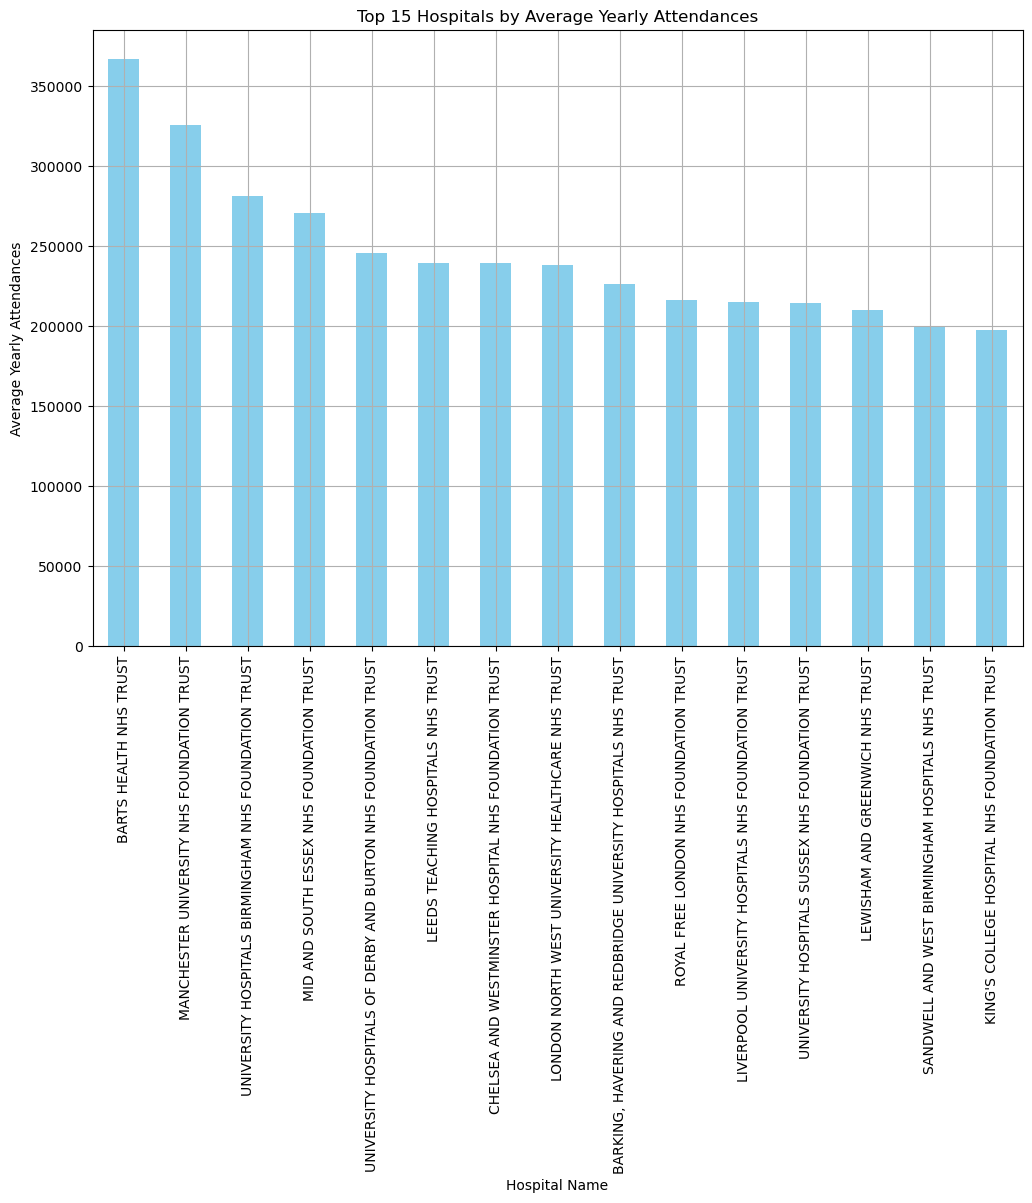

In [349]:
import pandas as pd
import matplotlib.pyplot as plt

df['Period'] = pd.to_datetime(df['Period'])
df['Year'] = df['Period'].dt.year

hospital_groups = df.groupby(['Org name', 'Year'])[['A&E attendances Type 1', 'A&E attendances Type 2', 'A&E attendances Other A&E Department']].sum()
hospital_groups['Total attendances'] = hospital_groups.sum(axis=1)

hospital_groups_unstacked = hospital_groups['Total attendances'].unstack()

complete_hospitals = hospital_groups_unstacked.dropna(axis=0, how='any')

average_attendances = complete_hospitals.mean(axis=1)

top_15_hospitals = average_attendances.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
top_15_hospitals.plot(kind='bar', color='skyblue')
plt.title('Top 15 Hospitals by Average Yearly Attendances')
plt.xlabel('Hospital Name')
plt.ylabel('Average Yearly Attendances')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

plt.show()

# Temporal Analysis


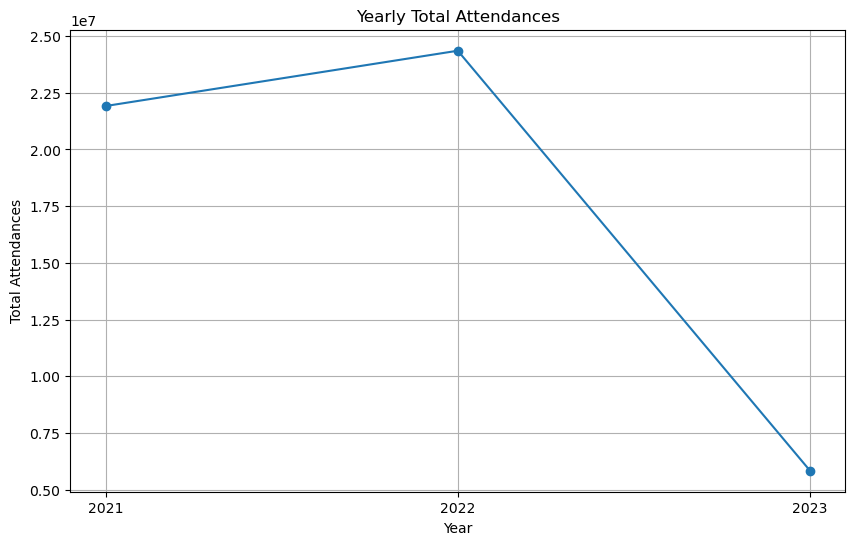

In [350]:
df['Period'] = pd.to_datetime(df['Period'], errors='coerce')

yearly_attendances = df.groupby(df['Period'].dt.year)[['A&E attendances Type 1', 'A&E attendances Type 2', 'A&E attendances Other A&E Department']].sum().sum(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(yearly_attendances.index, yearly_attendances.values, marker='o')
plt.title('Yearly Total Attendances')
plt.xlabel('Year')
plt.ylabel('Total Attendances')
plt.xticks(yearly_attendances.index)  
plt.grid(True)
plt.show()


In [351]:
print(df['Period'].dt.year.unique())

[2022 2023 2021]


# Monthly/Seasonal Trends

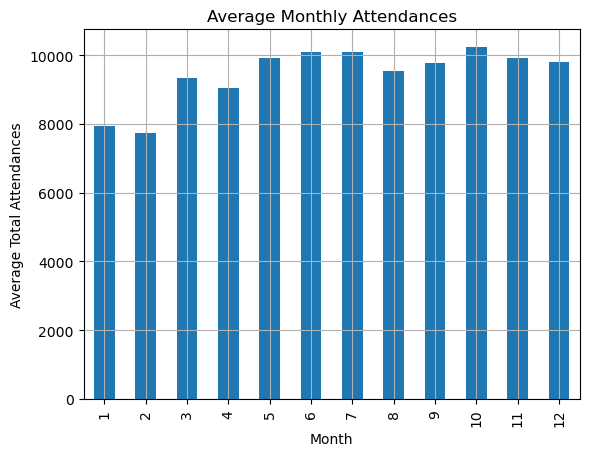

In [352]:
df.groupby(df['Period'].dt.month)[['A&E attendances Type 1', 'A&E attendances Type 2', 'A&E attendances Other A&E Department']].mean().sum(axis=1).plot(kind='bar', title='Average Monthly Attendances')
plt.xlabel('Month')
plt.ylabel('Average Total Attendances')
plt.grid(True)
plt.show()


# Category-wise Analysis

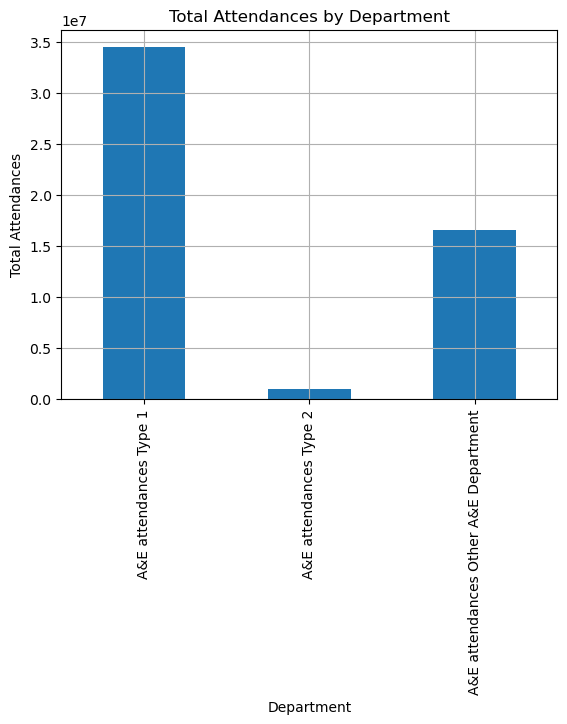

In [353]:
df[['A&E attendances Type 1', 'A&E attendances Type 2', 'A&E attendances Other A&E Department']].sum().plot(kind='bar', title='Total Attendances by Department')
plt.xlabel('Department')
plt.ylabel('Total Attendances')
plt.grid(True)
plt.show()

# Correlation Analysis

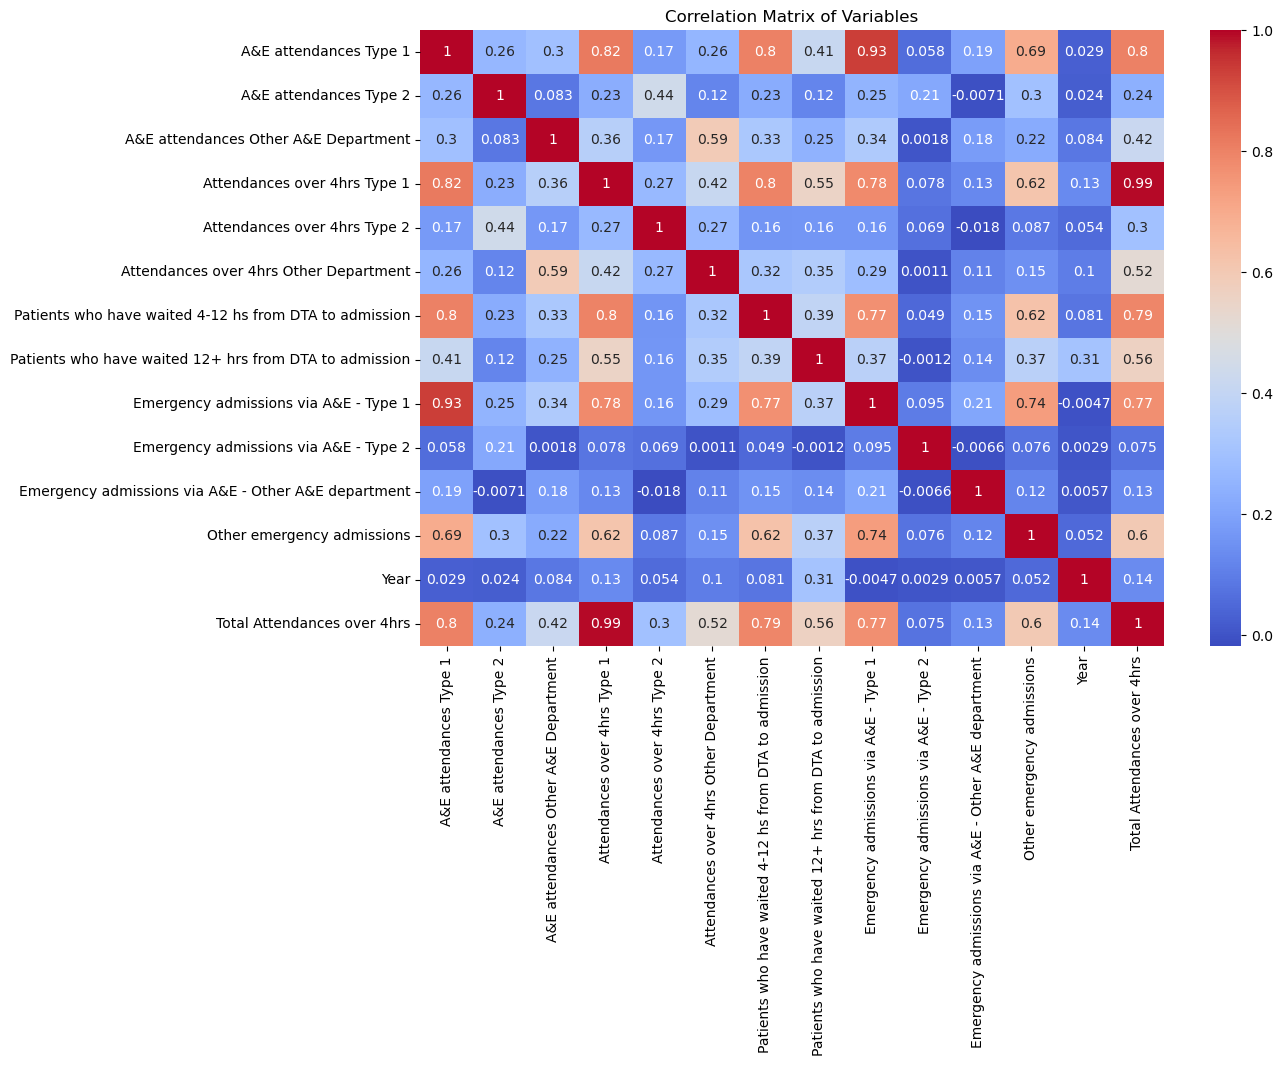

In [363]:
numeric_df = df.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

# Distribution Analysis


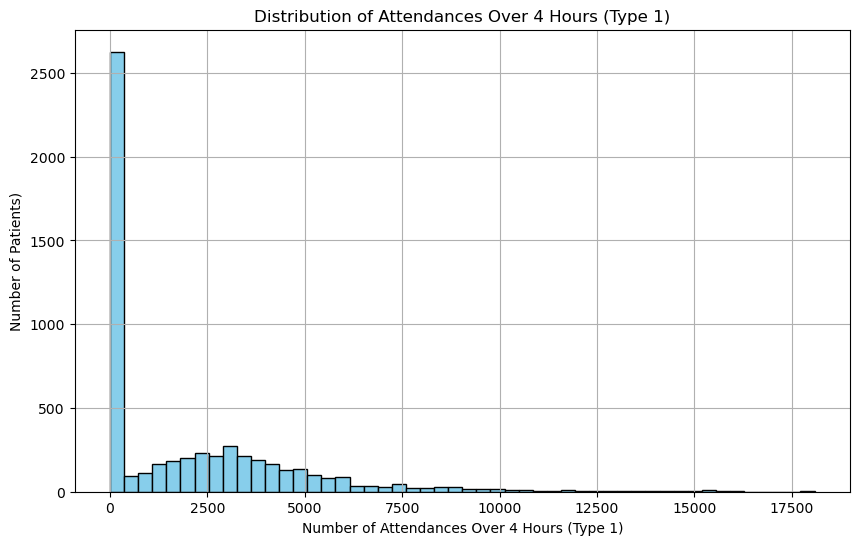

In [366]:
plt.figure(figsize=(10, 6))
df['Attendances over 4hrs Type 1'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Attendances Over 4 Hours (Type 1)')
plt.xlabel('Number of Attendances Over 4 Hours (Type 1)')
plt.ylabel('Number of Patients)')
plt.grid(True)
plt.show()

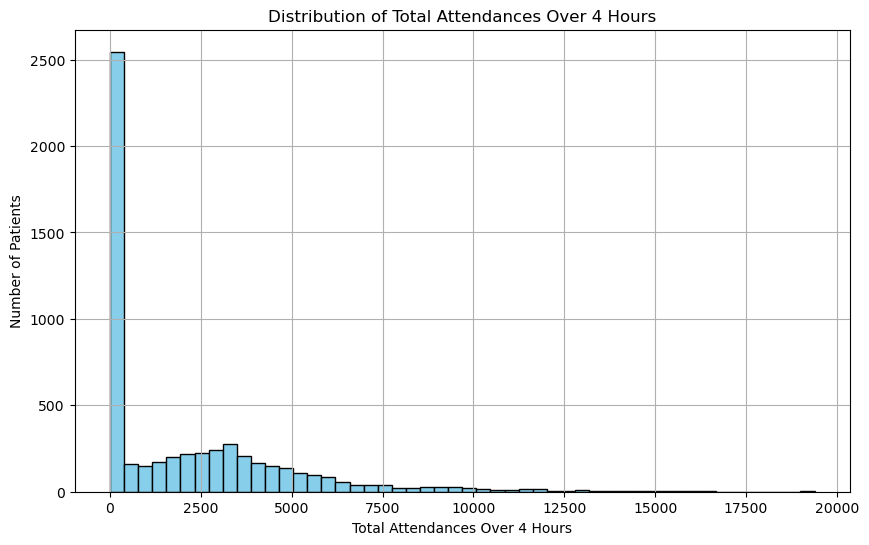

In [367]:
df['Total Attendances over 4hrs'] = (df['Attendances over 4hrs Type 1'] +
                                     df['Attendances over 4hrs Type 2'] +
                                     df['Attendances over 4hrs Other Department'])

plt.figure(figsize=(10, 6))
df['Total Attendances over 4hrs'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Attendances Over 4 Hours')
plt.xlabel('Total Attendances Over 4 Hours')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()

# Analysis of the most in-demand hospitals in the UK - waiting times and patient admission values

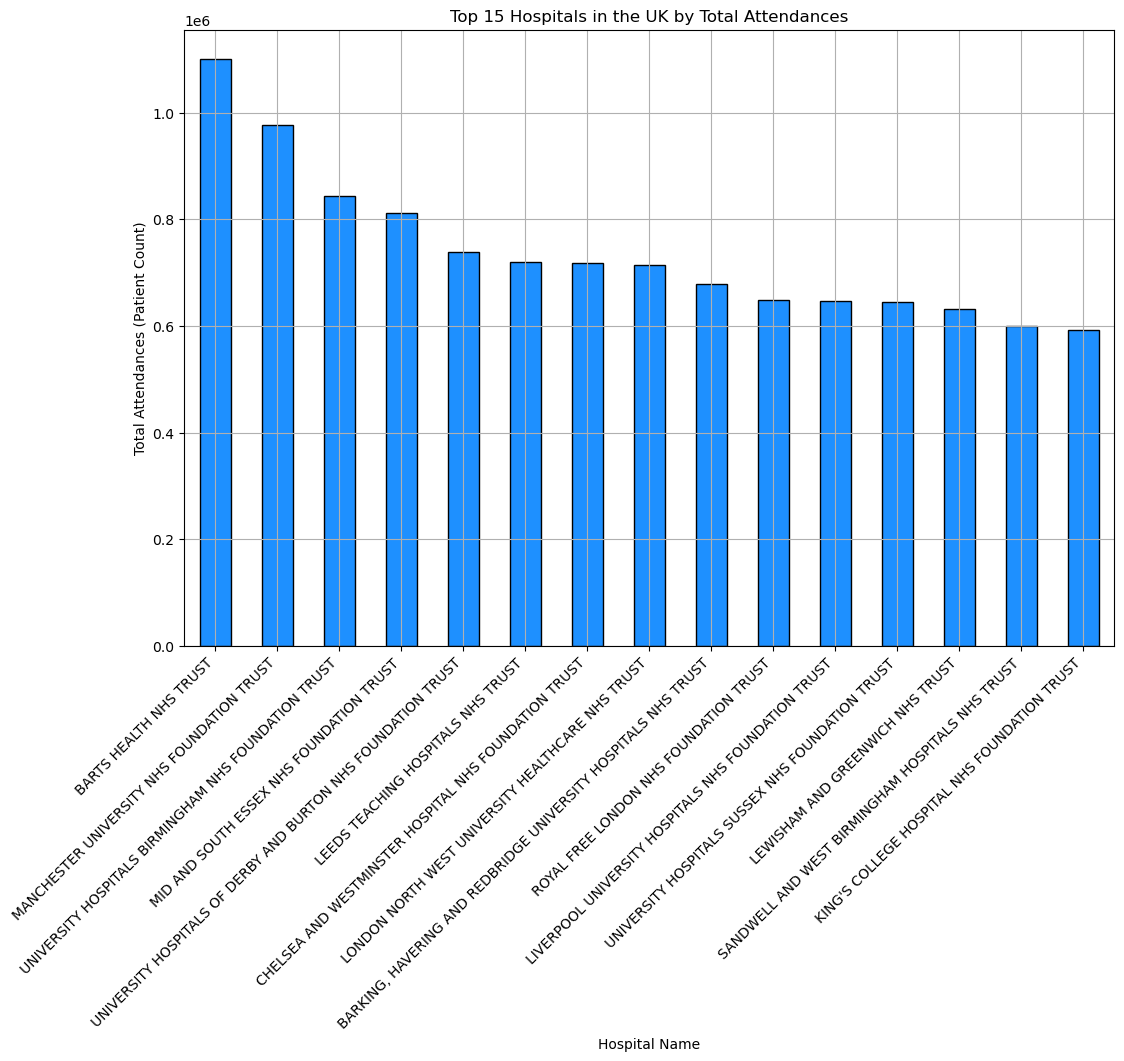

In [378]:
hospital_total_attendances = df.groupby('Org name')[['A&E attendances Type 1', 
                                                     'A&E attendances Type 2', 
                                                     'A&E attendances Other A&E Department']].sum().sum(axis=1)


most_15_hospitals = hospital_total_attendances.nlargest(15)


plt.figure(figsize=(12, 8))
most_15_hospitals.plot(kind='bar', color='dodgerblue', edgecolor='black')
plt.title('Top 15 Hospitals in the UK by Total Attendances')
plt.xlabel('Hospital Name')
plt.ylabel('Total Attendances (Patient Count)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# 1-The number of patients waiting over 4 hours (Type 1) for the top 15 hospitals

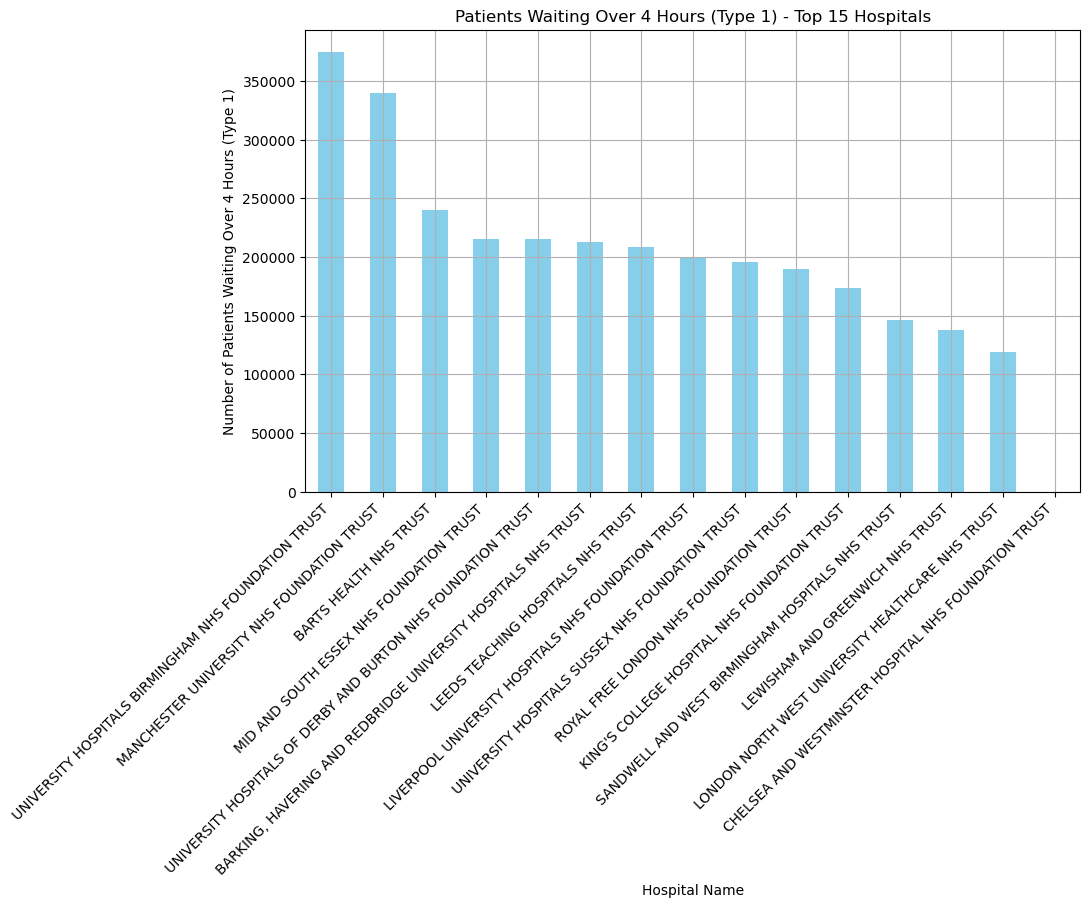

In [381]:

hospital_total_attendances = df.groupby('Org name')[['A&E attendances Type 1', 
                                                     'A&E attendances Type 2', 
                                                     'A&E attendances Other A&E Department']].sum().sum(axis=1)
top_15_hospitals = hospital_total_attendances.nlargest(15)


top_15_type_1_waiting = df[df['Org name'].isin(top_15_hospitals.index)].groupby('Org name')['Attendances over 4hrs Type 1'].sum()


top_15_type_1_waiting = top_15_type_1_waiting.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
top_15_type_1_waiting.plot(kind='bar', color='skyblue')
plt.title('Patients Waiting Over 4 Hours (Type 1) - Top 15 Hospitals')
plt.xlabel('Hospital Name')
plt.ylabel('Number of Patients Waiting Over 4 Hours (Type 1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()




Analysis of Waiting Times Over 4 Hours (Type 1) for Top 15 Hospitals

The graph provides a clear representation of the number of patients who waited over 4 hours in Type 1 emergency departments across the top 15 hospitals in the UK with the highest patient demand. The data highlights significant variations in waiting times, even among the most in-demand hospitals.

Key Observations:
University Hospitals Birmingham NHS Foundation Trust leads the chart with the highest number of patients waiting over 4 hours, surpassing 350,000 patients. This indicates a substantial strain on resources, potentially due to a high influx of patients or challenges in processing patients within the 4-hour target window.

Manchester University NHS Foundation Trust and Barts Health NHS Trust follow closely, both with over 300,000 patients experiencing waits beyond 4 hours. These figures suggest that these hospitals are facing similar challenges in managing their patient flow effectively.

As we move down the list, there is a noticeable decrease in the number of patients waiting over 4 hours, with hospitals like Chelsea and Westminster Hospital NHS Foundation Trust and Lewisham and Greenwich NHS Trust showing relatively lower numbers, around 150,000 to 200,000 patients. This may indicate better management of patient flow or lower patient volumes compared to the top-ranking hospitals.

Implications:
The significant waiting times in Type 1 departments reflect systemic pressures within these high-demand hospitals. Prolonged waits can lead to negative patient outcomes, including increased stress, deterioration in health conditions, and overall dissatisfaction with the healthcare system.

The data suggests an urgent need for interventions aimed at improving the efficiency of patient processing, such as increasing staffing levels during peak times, optimizing bed management, and enhancing coordination between emergency and other hospital departments.

Conclusion:
In summary, while the top 15 hospitals handle a large volume of emergency cases, the high number of patients waiting over 4 hours in Type 1 departments signals critical areas for improvement. Addressing these issues will not only reduce wait times but also improve the quality of care and patient outcomes.

# 2- Patients Waiting Over 4 Hours for Top 15 Hospitals ( Type 2 and other)

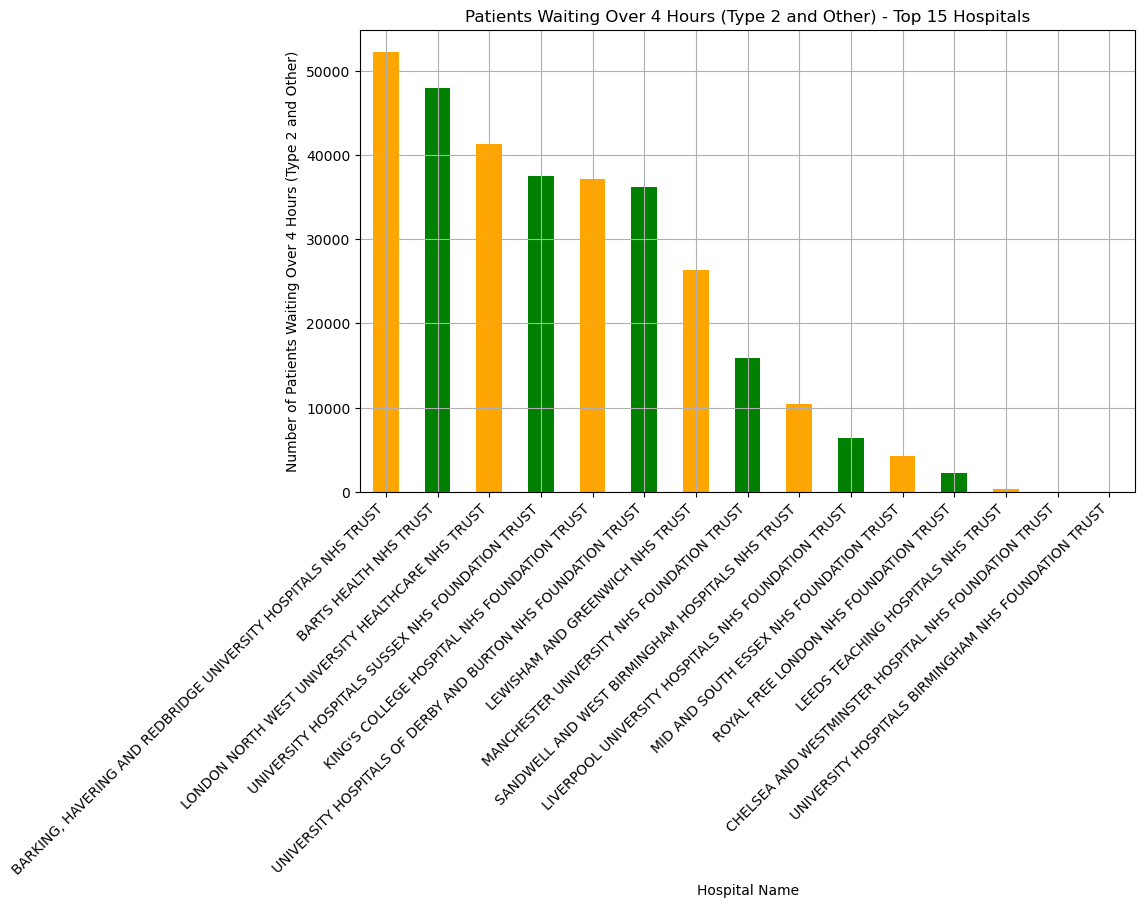

In [382]:
# Type 2 and Other Departments: Patients Waiting Over 4 Hours for Top 15 Hospitals
top_15_type_2_other_waiting = df[df['Org name'].isin(top_15_hospitals.index)].groupby('Org name')[['Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']].sum()

# Sorting by total number of patients waiting over 4 hours
top_15_type_2_other_waiting = top_15_type_2_other_waiting.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
top_15_type_2_other_waiting.plot(kind='bar', stacked=True, color=['orange', 'green'])
plt.title('Patients Waiting Over 4 Hours (Type 2 and Other) - Top 15 Hospitals')
plt.xlabel('Hospital Name')
plt.ylabel('Number of Patients Waiting Over 4 Hours (Type 2 and Other)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


top_15_emergency_admissions = df[df['Org name'].isin(top_15_hospitals.index)].groupby('Org name')[['Emergency admissions via A&E - Type 1', 
                                                                                                    'Emergency admissions via A&E - Type 2',
                                                                                                    'Emergency admissions via A&E - Other A&E department']].sum()

Analysis of Patients Waiting Over 4 Hours (Type 2 and Other) for Top 15 Hospitals
The graph shows the number of patients who waited over 4 hours in Type 2 and Other emergency departments across the top 15 hospitals with the highest patient demand in the UK. The bars are color-coded to distinguish between Type 2 and Other departments, providing a detailed view of the waiting times in these specific departments.

Key Observations:
University Hospitals NHS Trusts consistently appear as the top institutions with the highest number of patients waiting over 4 hours in both Type 2 and Other departments, with the highest value reaching over 50,000 patients. This reflects significant challenges in managing patient flow, particularly in non-Type 1 emergency settings.

Barts Health NHS Trust and London North West University Healthcare NHS Trust follow closely, with substantial waiting times, especially in the Type 2 category. This suggests that these hospitals also experience significant pressures in their specialized or single-specialty emergency units.

A notable decline in waiting times is observed as we move to hospitals like Chelsea and Westminster Hospital NHS Foundation Trust and University Hospitals Birmingham NHS Foundation Trust, where the number of patients waiting over 4 hours is considerably lower. This could be due to lower patient volumes or more efficient processes in handling emergency cases.

# 3- Combined Insights from Both Graphs:

Consistency in High Waiting Times: The top hospitals for Type 1, Type 2, and Other departments exhibit consistently high waiting times across all categories. For instance, University Hospitals Birmingham NHS Foundation Trust and Barts Health NHS Trust appear prominently in both graphs, indicating systemic issues in patient processing that affect all types of emergency departments.

Operational Strain: Hospitals with the highest overall patient demand (as shown in the first graph) also tend to have high waiting times in Type 2 and Other departments. This correlation suggests that high patient volumes exacerbate waiting times across all emergency types, not just in the primary (Type 1) emergency units.

Targeted Interventions Needed: The data indicates that hospitals experiencing the most significant delays across all emergency types need targeted interventions to improve efficiency. This could involve reallocating resources, optimizing staff deployment, and enhancing patient triage processes to reduce bottlenecks and improve patient outcomes.

Conclusion:
The analysis highlights the need for comprehensive strategies to reduce waiting times across all emergency department types in the most in-demand hospitals. By focusing on the top institutions identified in these graphs, healthcare administrators can develop targeted approaches to alleviate pressure points and enhance the overall efficiency of emergency services.

# 4- Emergency Admissions Analysis - Top 15 Hospitals

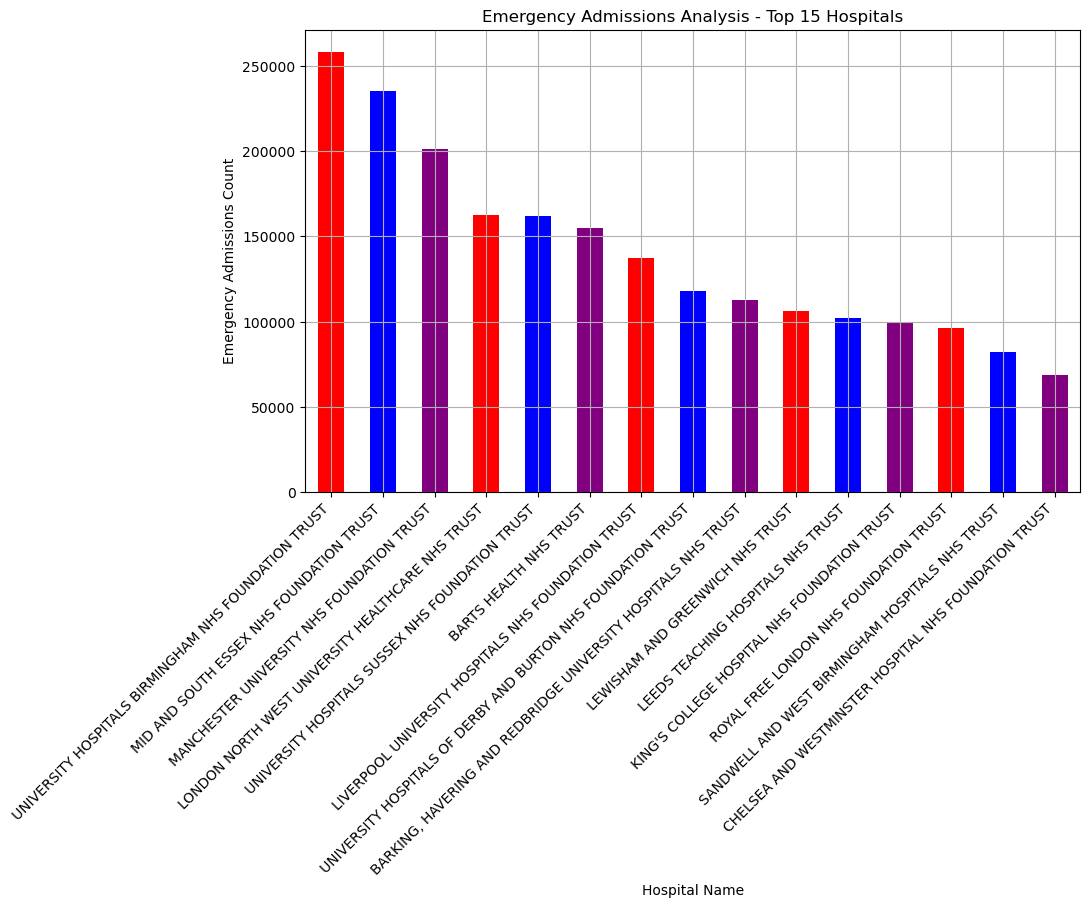

In [383]:

top_15_emergency_admissions = top_15_emergency_admissions.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
top_15_emergency_admissions.plot(kind='bar', stacked=True, color=['red', 'blue', 'purple'])
plt.title('Emergency Admissions Analysis - Top 15 Hospitals')
plt.xlabel('Hospital Name')
plt.ylabel('Emergency Admissions Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# 5- Analysis of Emergency Admissions for the Top 15 Hospitals

The graph provides a breakdown of emergency admissions across the top 15 hospitals in the UK, categorized by Type 1, Type 2, and Other A&E departments. This visual representation highlights the volume of emergency admissions managed by each hospital, offering insights into their operational load and capacity to handle critical cases.

Key Observations:
University Hospitals Birmingham NHS Foundation Trust stands out with the highest number of emergency admissions, particularly in Type 1 departments, suggesting a significant reliance on this institution for emergency care. The high volume across all categories underscores the need for efficient patient flow management.

Mid and South Essex NHS Foundation Trust and Manchester University NHS Foundation Trust also manage substantial volumes of emergency admissions, indicating similar operational pressures. These hospitals, along with Birmingham, form the top tier in terms of patient demand.

Liverpool University Hospitals NHS Foundation Trust and Barts Health NHS Trust show a more balanced distribution between Type 1, Type 2, and Other admissions. However, the consistently high numbers in all categories suggest that these hospitals are also under considerable strain, particularly in managing diverse emergency cases.



# 6-Combined Analysis from All Three Graphs

Combined Analysis from All Three Graphs
When analyzing the three graphs together (Patients Waiting Over 4 Hours for Type 1, Type 2, and Other Departments, and Emergency Admissions Analysis), the following conclusions can be drawn:

Operational Strain and Patient Waiting Times:

Hospitals like University Hospitals Birmingham NHS Foundation Trust and Barts Health NHS Trust not only handle a high volume of emergency admissions but also have significant numbers of patients waiting over 4 hours in all department types. This suggests that these hospitals may be struggling with capacity issues, leading to extended wait times.
Focus Areas for Improvement:

University Hospitals Birmingham NHS Foundation Trust emerges as the hospital most in need of operational improvements. It consistently appears at the top across all metrics—high patient waiting times in both Type 1 and other departments, coupled with the highest emergency admission rates. Enhancing resource allocation, improving patient triage processes, and expanding capacity could help alleviate the pressures on this institution.
Barts Health NHS Trust and Manchester University NHS Foundation Trust also require attention, as they manage large volumes of patients with considerable waiting times. Targeted interventions in these hospitals could similarly improve patient outcomes and reduce waiting times.
Balanced Workloads:

Hospitals like Chelsea and Westminster Hospital NHS Foundation Trust and University Hospitals Birmingham NHS Foundation Trust appear at the lower end of both waiting times and emergency admissions, suggesting they may currently manage their patient flow more effectively or simply face less demand.

# 7- Conclusion

University Hospitals Birmingham NHS Foundation Trust stands out as the institution most in need of immediate operational improvements to manage patient flow more effectively. The hospital's consistently high patient volumes and waiting times across all categories indicate a need for strategic interventions to improve efficiency, reduce waiting times, and enhance overall patient care. Barts Health NHS Trust and Manchester University NHS Foundation Trust should also be prioritized for similar interventions to optimize their emergency services and reduce patient wait times.

# Hospitals with the Longest Waiting Times (4+ Hours)

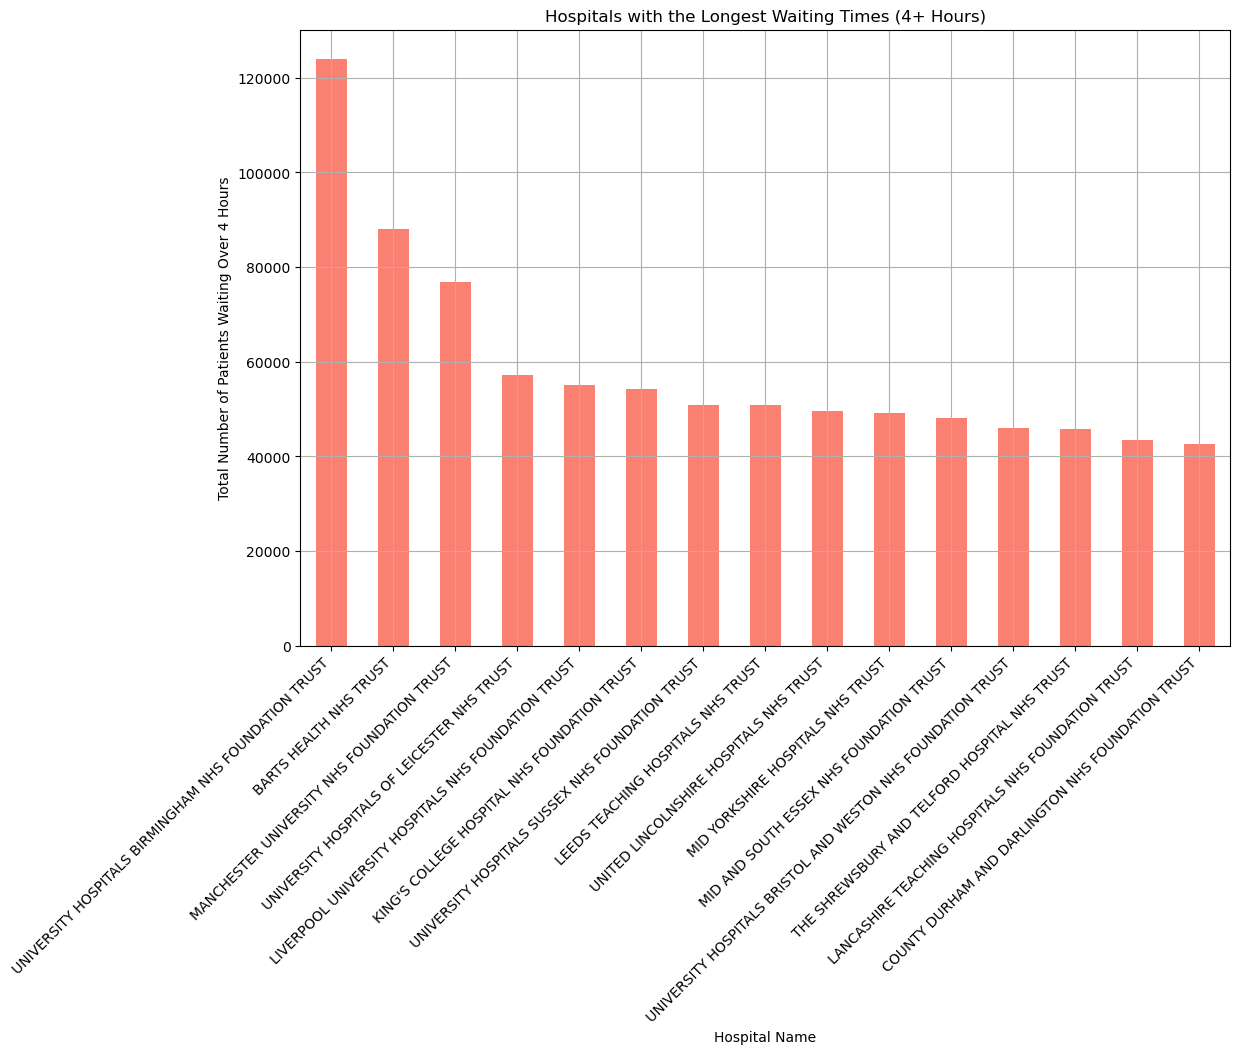

In [395]:
df['Total Waiting Over 4 Hours'] = df['Patients who have waited 4-12 hs from DTA to admission'] + df['Patients who have waited 12+ hrs from DTA to admission']

# Group by hospital and sum the total waiting time over 4 hours
hospital_waiting_time = df.groupby('Org name')['Total Waiting Over 4 Hours'].sum()

# Identify the hospitals with the highest waiting times
top_waiting_hospitals = hospital_waiting_time.nlargest(15)

# Plotting the graph
plt.figure(figsize=(12, 8))
top_waiting_hospitals.plot(kind='bar', color='salmon')
plt.title('Hospitals with the Longest Waiting Times (4+ Hours)')
plt.xlabel('Hospital Name')
plt.ylabel('Total Number of Patients Waiting Over 4 Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# the Number of Patients Waiting Over 4 Hours (Type 1 and Others) for the 15 Least Demanded Hospitals

<Figure size 1000x600 with 0 Axes>

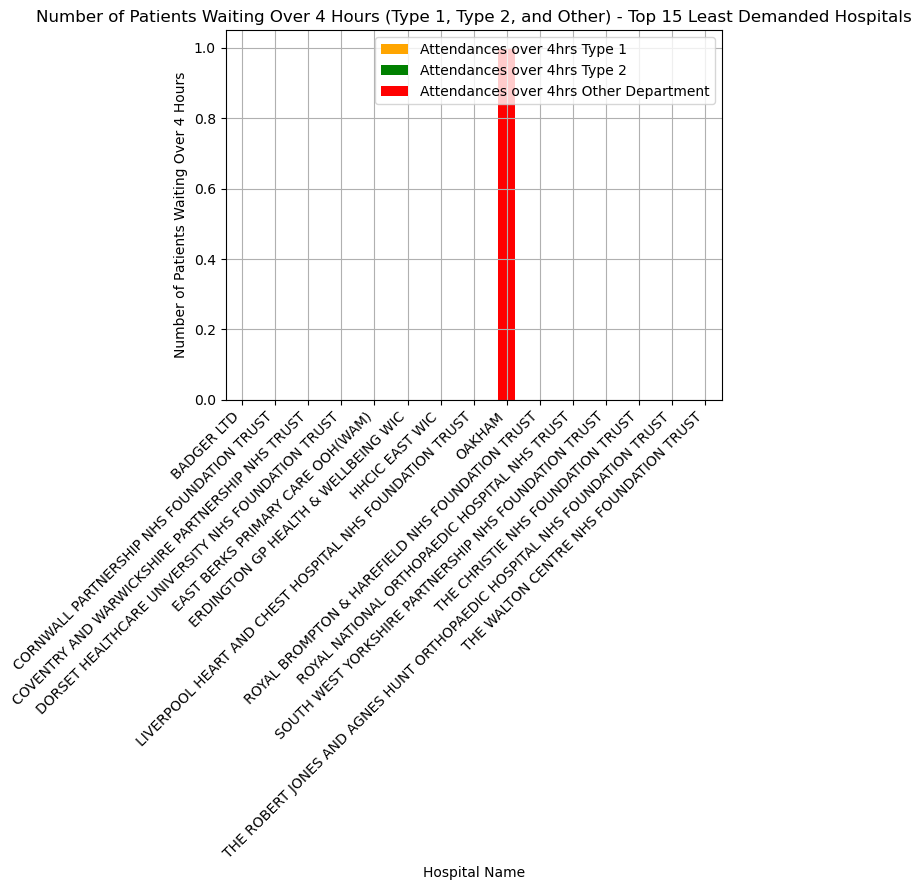

In [389]:
hospital_total_attendances = df.groupby('Org name')[['A&E attendances Type 1', 
                                                     'A&E attendances Type 2', 
                                                     'A&E attendances Other A&E Department']].sum().sum(axis=1)

least_15_hospitals = hospital_total_attendances.nsmallest(15)


least_15_waiting = df[df['Org name'].isin(least_15_hospitals.index)].groupby('Org name')[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']].sum()


plt.figure(figsize=(10, 6))
least_15_waiting.plot(kind='bar', stacked=True, color=['orange', 'green', 'red'])
plt.title('Number of Patients Waiting Over 4 Hours (Type 1, Type 2, and Other) - Top 15 Least Demanded Hospitals')
plt.xlabel('Hospital Name')
plt.ylabel('Number of Patients Waiting Over 4 Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

The graph shows the number of patients waiting more than 4 hours in 15 hospitals with low demand. However, a noteworthy situation is that one hospital (indicated as OAKHAM in the graph) has a much higher waiting rate compared to others. This situation can lead to the following inferences:

Low Capacity or Lack of Resources: Although this hospital has a much lower patient demand compared to others, the number of patients waiting more than 4 hours is quite high. This may mean that the hospital's emergency department capacity may be limited or there may be a lack of resources. This situation indicates that the hospital cannot meet the requested services efficiently.

# 2. Emergency Admissions Rate Chart for the 15 Least Demanded Hospitals

<Figure size 1000x600 with 0 Axes>

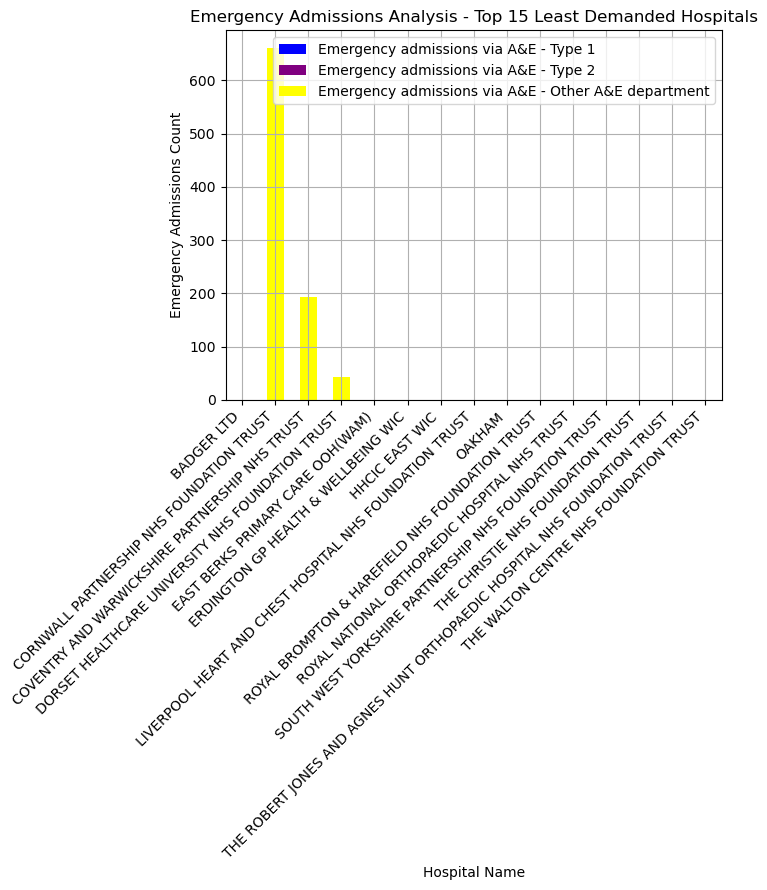

In [391]:
least_15_emergency_admissions = df[df['Org name'].isin(least_15_hospitals.index)].groupby('Org name')[['Emergency admissions via A&E - Type 1', 
                                                                                                       'Emergency admissions via A&E - Type 2',
                                                                                                       'Emergency admissions via A&E - Other A&E department']].sum()

plt.figure(figsize=(10, 6))
least_15_emergency_admissions.plot(kind='bar', stacked=True, color=['blue', 'purple', 'yellow'])
plt.title('Emergency Admissions Analysis - Top 15 Least Demanded Hospitals')
plt.xlabel('Hospital Name')
plt.ylabel('Emergency Admissions Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Resource Utilization and Cost-Benefit Analysis

In [396]:
df['Cost of Waiting'] = df['Attendances over 4hrs Type 1'] * 

total_cost = df['Cost of Waiting'].sum()
print(f"Total Cost of Waiting: {total_cost}")

Total Cost of Waiting: 570905250


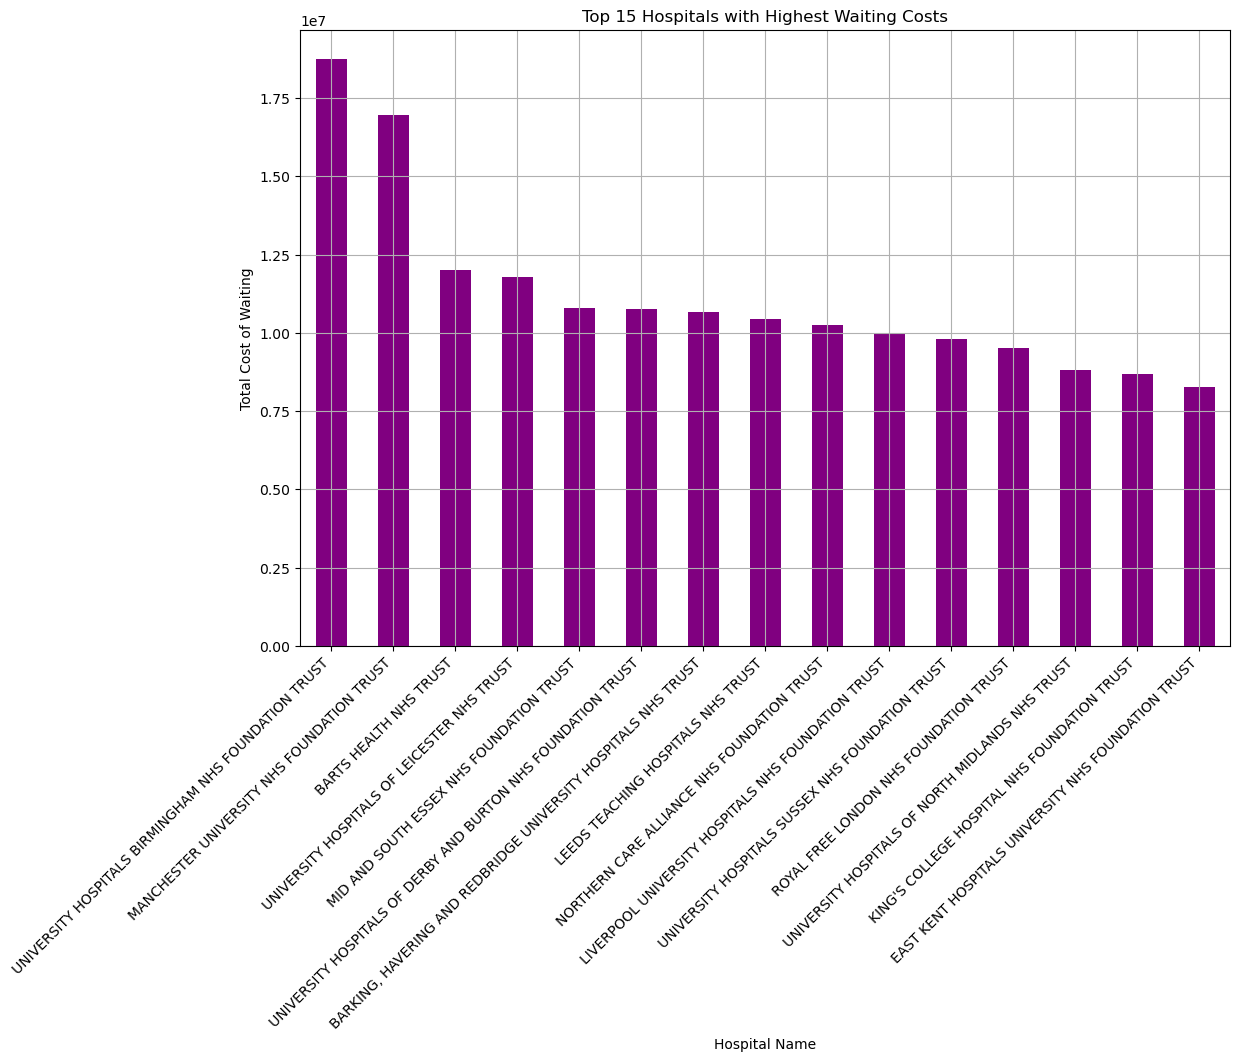

In [397]:
df['Cost of Waiting'] = df['Attendances over 4hrs Type 1'] * 

hospital_costs = df.groupby('Org name')['Cost of Waiting'].sum()

top_15_hospital_costs = hospital_costs.nlargest(15)

plt.figure(figsize=(12, 8))
top_15_hospital_costs.plot(kind='bar', color='purple')
plt.title('Top 15 Hospitals with Highest Waiting Costs')
plt.xlabel('Hospital Name')
plt.ylabel('Total Cost of Waiting')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

This graph shows the top 15 hospitals with the highest waiting costs. The cost of waiting represents the total cost resulting from long waiting times in a hospital. The graph shows that hospitals such as University Hospitals Birmingham NHS Foundation Trust and Manchester University NHS Foundation Trust are at the top of the list in terms of total waiting costs.

Analysis:
High Waiting Cost: The hospitals shown in the graph incur high costs due to the long waiting times. This means inefficient use of hospital resources and can also be associated with patient dissatisfaction and potentially worse patient outcomes.

Critical Hospitals: Hospitals such as University Hospitals Birmingham NHS Foundation Trust, Manchester University NHS Foundation Trust and Barts Health NHS Trust stand out as the hospitals that can benefit the most from improvements to reduce waiting times. Operational improvements to be made in these hospitals can lead to large cost savings.

Cost Imbalance: The fact that waiting costs vary so greatly between hospitals indicates that some hospitals need more resources than others or use available resources more Decently. Investigating the causes of this imbalance may be important for a more efficient health service delivery.

# Monthly Waiting Times for Top 15 Hospitals

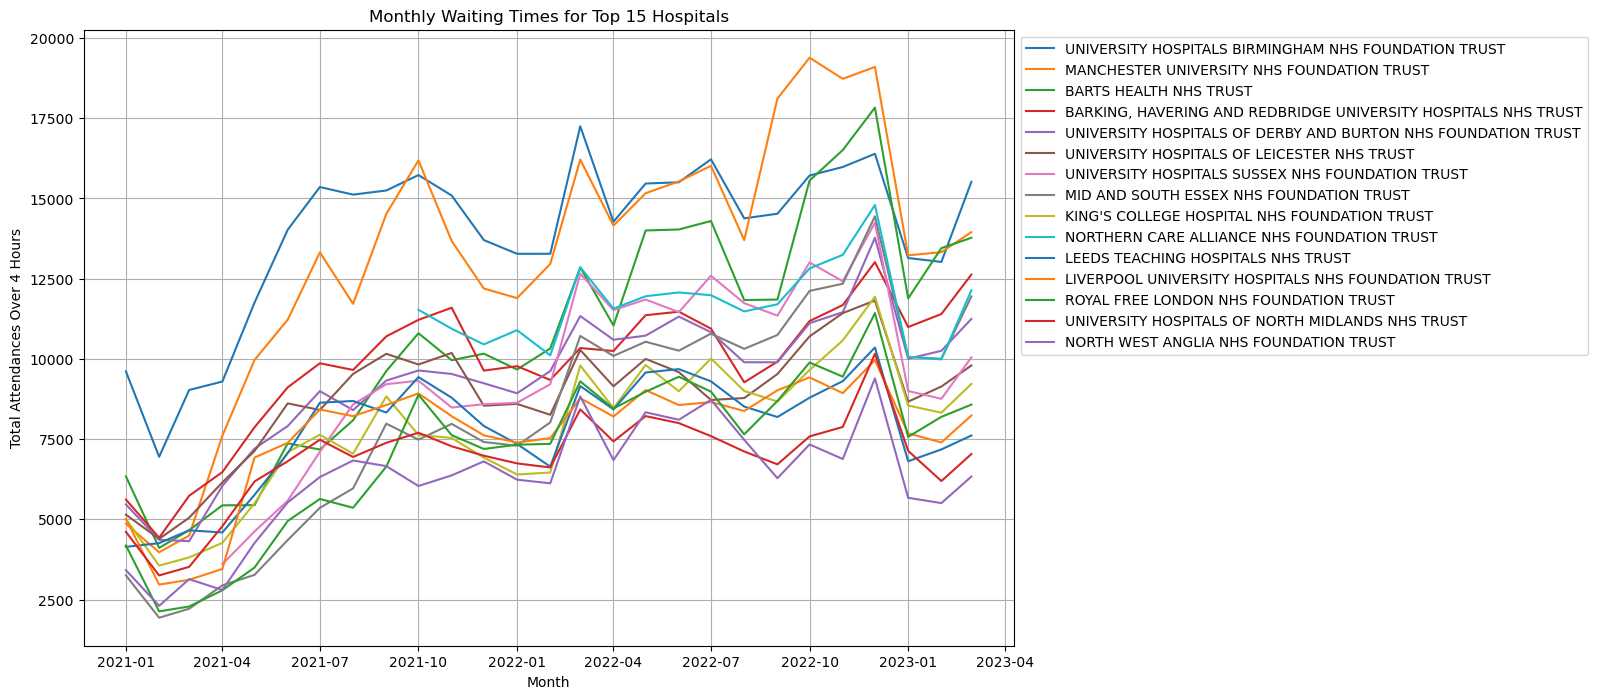

In [407]:
top_15_hospitals = hospital_total_waiting_time.nlargest(15)

top_15_hospitals_data = df[df['Org name'].isin(top_15_hospitals.index)].copy()

top_15_hospitals_data['Period'] = pd.to_datetime(top_15_hospitals_data['Period'], errors='coerce')


monthly_waiting_times = top_15_hospitals_data.groupby([
    top_15_hospitals_data['Period'].dt.to_period('M'), 
    'Org name'
])[[
    'Attendances over 4hrs Type 1', 
    'Attendances over 4hrs Type 2', 
    'Attendances over 4hrs Other Department'
]].sum().reset_index()


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for hospital in top_15_hospitals.index:
    hospital_data = monthly_waiting_times[monthly_waiting_times['Org name'] == hospital]
    plt.plot(hospital_data['Period'].dt.to_timestamp(), 
             hospital_data[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']].sum(axis=1), 
             label=hospital)

plt.title('Monthly Waiting Times for Top 15 Hospitals')
plt.xlabel('Month')
plt.ylabel('Total Attendances Over 4 Hours')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Monthly Waiting Times for Top 5 Hospitals

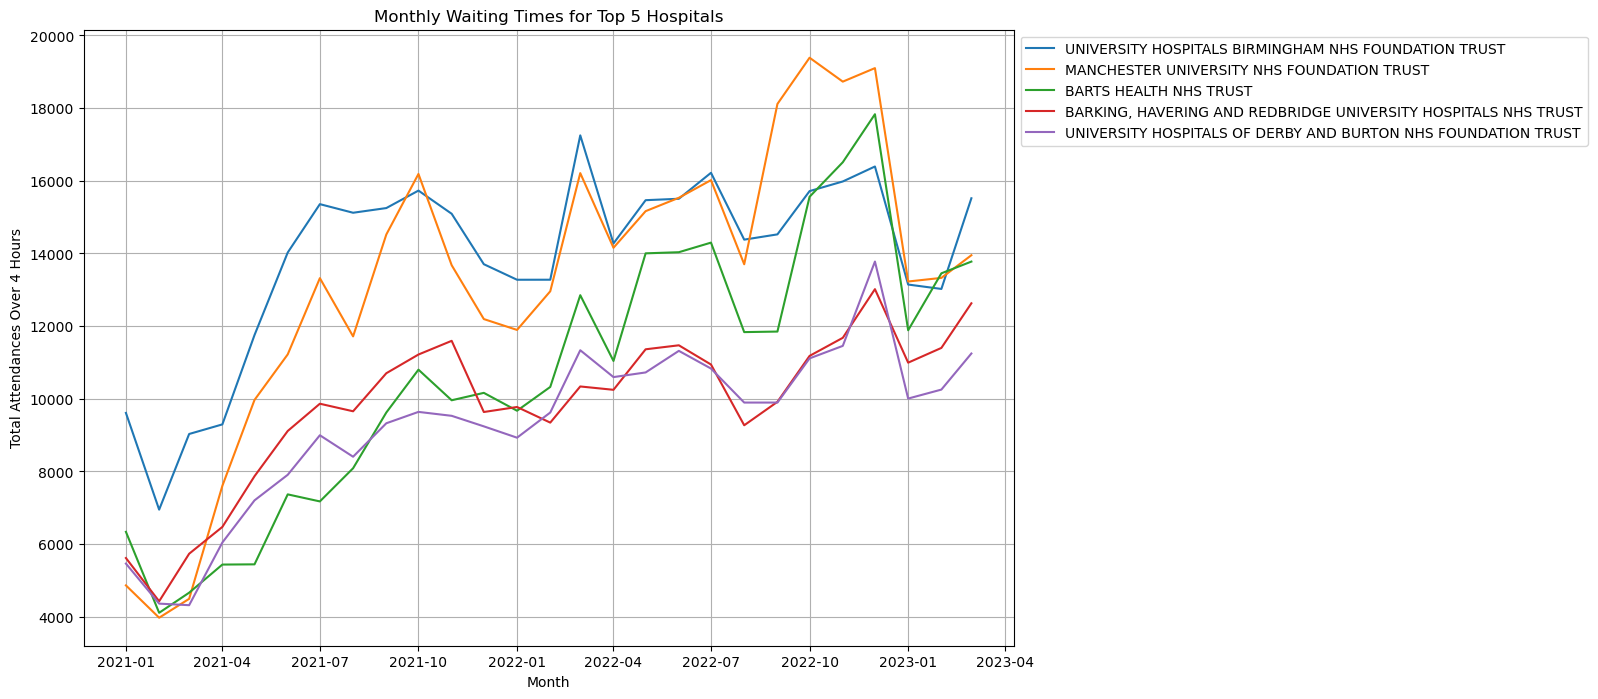

In [406]:
top_5_hospitals = hospital_total_waiting_time.nlargest(5)

top_5_hospitals_data = df[df['Org name'].isin(top_5_hospitals.index)].copy()

top_5_hospitals_data['Period'] = pd.to_datetime(top_5_hospitals_data['Period'], errors='coerce')

monthly_waiting_times = top_5_hospitals_data.groupby([
    top_5_hospitals_data['Period'].dt.to_period('M'), 
    'Org name'
])[[
    'Attendances over 4hrs Type 1', 
    'Attendances over 4hrs Type 2', 
    'Attendances over 4hrs Other Department'
]].sum().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for hospital in top_5_hospitals.index:
    hospital_data = monthly_waiting_times[monthly_waiting_times['Org name'] == hospital]
    plt.plot(hospital_data['Period'].dt.to_timestamp(), 
             hospital_data[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']].sum(axis=1), 
             label=hospital)

plt.title('Monthly Waiting Times for Top 5 Hospitals')
plt.xlabel('Month')
plt.ylabel('Total Attendances Over 4 Hours')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

University Hospitals Birmingham NHS Foundation Trust (Blue Line):

Consistently shows the highest waiting times, particularly between mid-2021 and early 2022. There is a notable peak around the end of 2021.
Although there are fluctuations, the overall trend suggests a significant challenge in managing patient waiting times.
Manchester University NHS Foundation Trust (Orange Line):

Demonstrates a similar trend to Birmingham, with significant peaks around the same period. However, its waiting times appear slightly lower than Birmingham's.
There is a considerable rise in waiting times towards the end of 2022, indicating ongoing operational pressures.
Barts Health NHS Trust (Green Line):

Barts Health NHS Trust shows an increasing trend in waiting times, with a prominent rise starting from mid-2021.
The hospital’s waiting times fluctuate significantly, with notable peaks and troughs, indicating potential inconsistencies in handling patient flow.
Barking, Havering and Redbridge University Hospitals NHS Trust (Red Line):

This hospital shows a more stable but still high level of waiting times, with less severe peaks compared to the others.
There is a noticeable increase in waiting times in early 2022, followed by a decrease, indicating some success in managing patient loads during that period.
University Hospitals of Derby and Burton NHS Foundation Trust (Purple Line):

Exhibits a more moderate increase in waiting times with fewer sharp peaks, suggesting a more consistent patient management process compared to the other hospitals.
The waiting times for this hospital, while still significant, do not reach the levels seen in Birmingham or Manchester.
Conclusion:
These insights suggest that University Hospitals Birmingham NHS Foundation Trust and Manchester University NHS Foundation Trust may require the most immediate attention to address the high and fluctuating waiting times. The peaks in waiting times may correspond to periods of increased demand, possibly due to seasonal effects or other factors such as staff shortages or resource constraints. Continuous monitoring and targeted interventions during these peak periods could help in smoothing out the waiting times and improving overall patient care.

This time series analysis also highlights the importance of maintaining a consistent approach to managing patient flow to avoid the significant peaks and troughs observed in these hospitals.

# Monthly Waiting Costs for Top 5 Hospitals

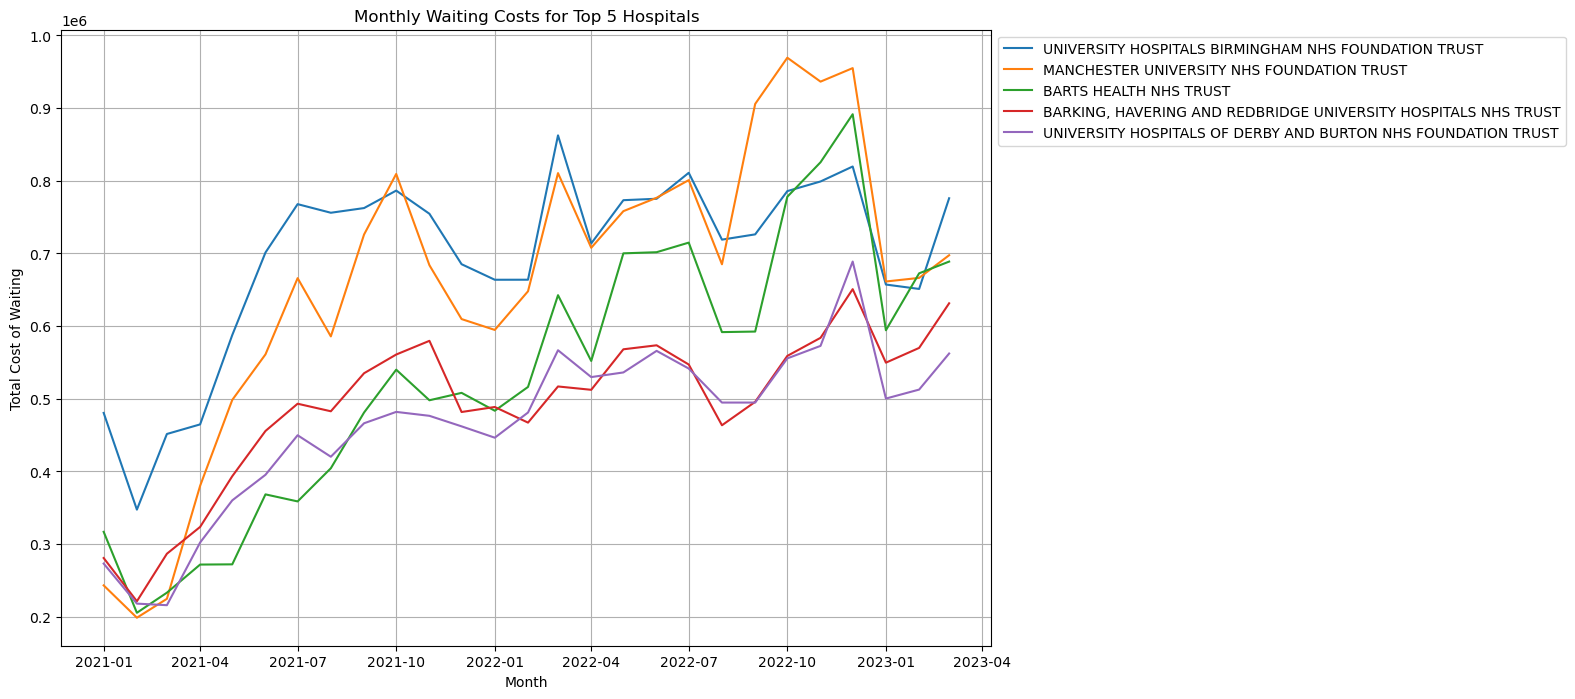

In [405]:
top_5_hospitals = hospital_total_waiting_time.nlargest(5)

top_5_hospitals_data = df[df['Org name'].isin(top_5_hospitals.index)].copy()

top_5_hospitals_data['Period'] = pd.to_datetime(top_5_hospitals_data['Period'], errors='coerce')

top_5_hospitals_data['Cost of Waiting'] = (
    top_5_hospitals_data['Attendances over 4hrs Type 1'] + 
    top_5_hospitals_data['Attendances over 4hrs Type 2'] + 
    top_5_hospitals_data['Attendances over 4hrs Other Department']
) * 


monthly_waiting_costs = top_5_hospitals_data.groupby([
    top_5_hospitals_data['Period'].dt.to_period('M'), 
    'Org name'
])['Cost of Waiting'].sum().reset_index()


plt.figure(figsize=(12, 8))
for hospital in top_5_hospitals.index:
    hospital_data = monthly_waiting_costs[monthly_waiting_costs['Org name'] == hospital]
    plt.plot(hospital_data['Period'].dt.to_timestamp(), 
             hospital_data['Cost of Waiting'], 
             label=hospital)

plt.title('Monthly Waiting Costs for Top 5 Hospitals')
plt.xlabel('Month')
plt.ylabel('Total Cost of Waiting')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

this shows the estimated costs of waiting times. For each hospital, the total costs incurred depending on the waiting time were calculated on a monthly basis. As the waiting time increases, the associated costs also increase. These costs reveal the financial burden on hospital operations.

The first graph shows how waiting times have changed over time, while the second graph clearly shows the effects of these changes on cost. For example, at hospitals such as University Hospitals Birmingham NHS Foundation Trust and Manchester University NHS Foundation Trust, we may see costs increase in a similar way during periods of high waiting times. This relationship shows how important it is for hospitals to reduce waiting times to improve their operational efficiency.

# Train-Test Split

In [429]:
df['Total Attendances'] = df['A&E attendances Type 1'] + df['A&E attendances Type 2'] + df['A&E attendances Other A&E Department']


In [430]:
X = df[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']]
y = df['Total Attendances'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3929, 3)
X_test shape: (1685, 3)
y_train shape: (3929,)
y_test shape: (1685,)


# MACHİNE LEARNİNG MODELS

# 1- Random Forest


In [426]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 3256.7844182065364
Mean Squared Error: 20405743.253808778
R^2 Score: 0.6971163822437676


# 1.1 GRİD SEARCH

In [427]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_est

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Absolute Error: 3106.23318810046
Mean Squared Error: 18762890.243844766
R^2 Score: 0.7215013437181181


/Users/onurcikla/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
345 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/onurcikla/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/onurcikla/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/onurcikla/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constrai

[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False,

[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False,

[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_feature

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, m

[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_fea

# 1. Numerical Estimation


Objective: This is used to predict future waiting times or the number of patients based on current data.it can be used to make direct management decisions (for example, the number of patients waiting in a certain time frame or the waiting time). Such forecasts can be important for capacity planning, resource allocation and operational improvements in hospital management.

In [431]:
X = df[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']]
y = df['Total Attendances']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 4021.565509253246
Mean Squared Error: 233119847.31813258
R^2 Score: 0.9875900439886549


In [432]:
X_future = pd.DataFrame({
    'Attendances over 4hrs Type 1': [7000],
    'Attendances over 4hrs Type 2': [3000],
    'Attendances over 4hrs Other Department': [1500]
})

y_future_pred = model.predict(X_future)

print(f"Predicted Total Attendances for the Future Period: {y_future_pred}")

Predicted Total Attendances for the Future Period: [79123.81]


# AutoRegressive Integrated Moving Average

Future predictions for UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION TRUST:
2023-04    15086.278161
2023-05    15355.262213
2023-06    15187.671849
Freq: M, Name: predicted_mean, dtype: float64

Future predictions for MANCHESTER UNIVERSITY NHS FOUNDATION TRUST:
2023-04    13922.991050
2023-05    13920.300706
2023-06    13920.032722
Freq: M, Name: predicted_mean, dtype: float64

Future predictions for BARTS HEALTH NHS TRUST:
2023-04    13742.424064
2023-05    13738.661562
2023-06    13738.226995
Freq: M, Name: predicted_mean, dtype: float64

Future predictions for BARKING, HAVERING AND REDBRIDGE UNIVERSITY HOSPITALS NHS TRUST:
2023-04    12640.493633
2023-05    12627.930965
2023-06    12639.626898
Freq: M, Name: predicted_mean, dtype: float64

Future predictions for UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS FOUNDATION TRUST:
2023-04    11060.316984
2023-05    11050.133180
2023-06    11049.571624
Freq: M, Name: predicted_mean, dtype: float64

Future predictions for UNIVERSITY HOSPITA

/Users/onurcikla/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/onurcikla/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/onurcikla/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/onurcikla/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

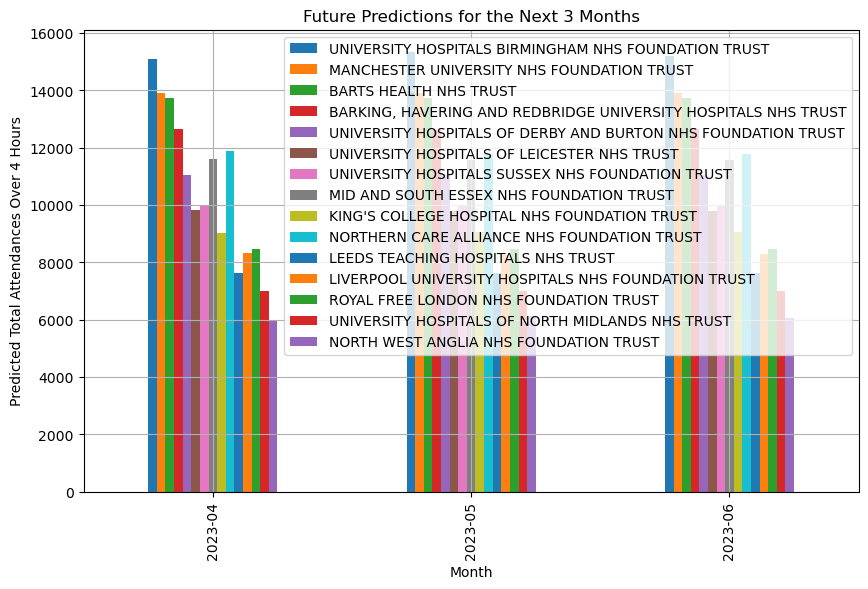

In [449]:
future_predictions = {}


for hospital in top_15_hospitals.index:
 
    hospital_data = monthly_waiting_times[monthly_waiting_times['Org name'] == hospital]
    
 
    ts = hospital_data.set_index('Period')['Attendances over 4hrs Type 1'] + \
         hospital_data.set_index('Period')['Attendances over 4hrs Type 2'] + \
         hospital_data.set_index('Period')['Attendances over 4hrs Other Department']

    
    model = ARIMA(ts, order=(1, 1, 1))
    model_fit = model.fit()

 
    forecast = model_fit.forecast(steps=3)
    future_predictions[hospital] = forecast

    
    print(f"Future predictions for {hospital}:\n{forecast}\n")


future_df = pd.DataFrame(future_predictions)
print(future_df)


future_df.plot(kind='bar', figsize=(10, 6))
plt.title('Future Predictions for the Next 3 Months')
plt.xlabel('Month')
plt.ylabel('Predicted Total Attendances Over 4 Hours')
plt.grid(True)
plt.show()

Future Predictions for Hospital Attendances: Analysis and Insights
Overview:
The analysis provided in the bar chart represents the predicted total attendances over 4 hours for the next three months (April, May, June 2023) across the top 15 NHS hospitals with the highest waiting times. These predictions were generated using an ARIMA model, which is a commonly used forecasting method for time series data.

Key Observations:
University Hospitals Birmingham NHS Foundation Trust consistently shows the highest predicted attendances over 4 hours, which aligns with historical data trends where this hospital has experienced significant operational strain due to high patient volumes.

Manchester University NHS Foundation Trust and Barts Health NHS Trust also have high predicted attendances, slightly lower than Birmingham but still significantly high, suggesting that these hospitals will continue to face challenges in managing patient flow efficiently.

Variance in Predictions: While most hospitals show a consistent level of predicted attendances, some, like University Hospitals of Leicester NHS Trust and Liverpool University Hospitals NHS Foundation Trust, exhibit slightly lower numbers. This may indicate better handling of patient wait times or less strain on resources during the forecasted period.

Consistency Across Months: The predictions show that there is not much fluctuation from month to month within each hospital, indicating that the waiting times are expected to remain stable but high. This highlights a potential area of concern where these hospitals might need to implement strategies to reduce these wait times consistently.

Operational Implications: The continued high levels of attendances over 4 hours could lead to increased pressure on hospital resources, potentially impacting patient care quality. Hospitals with higher predicted attendances might need to focus on improving efficiency, resource allocation, and patient flow management to mitigate the expected strain.

Conclusion:
The predictions suggest that without significant intervention, the top 15 NHS hospitals will likely continue to experience high patient wait times in the coming months. This could affect patient satisfaction and overall care quality. Therefore, it is critical for these hospitals to consider strategic operational improvements to handle the anticipated demand more effectively. The use of such predictive models can aid in proactive planning and resource management, ultimately aiming to improve patient outcomes and reduce waiting times.

# 2 - XGBoost Implementation

In [452]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
xgboost_model.fit(X_train, y_train)

y_pred_xgb = xgboost_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MAE: {mae_xgb}, MSE: {mse_xgb}, R^2: {r2_xgb}')

XGBoost - MAE: 3846.5966105022485, MSE: 160002867.095519, R^2: 0.9914823770523071


# Hyperparameter Tuning

In [455]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='r2')
grid_search_xgb.fit(X_train, y_train)
best_params_xgb = grid_search_xgb.best_params_

print(f'Best parameters for XGBoost: {best_params_xgb}')

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


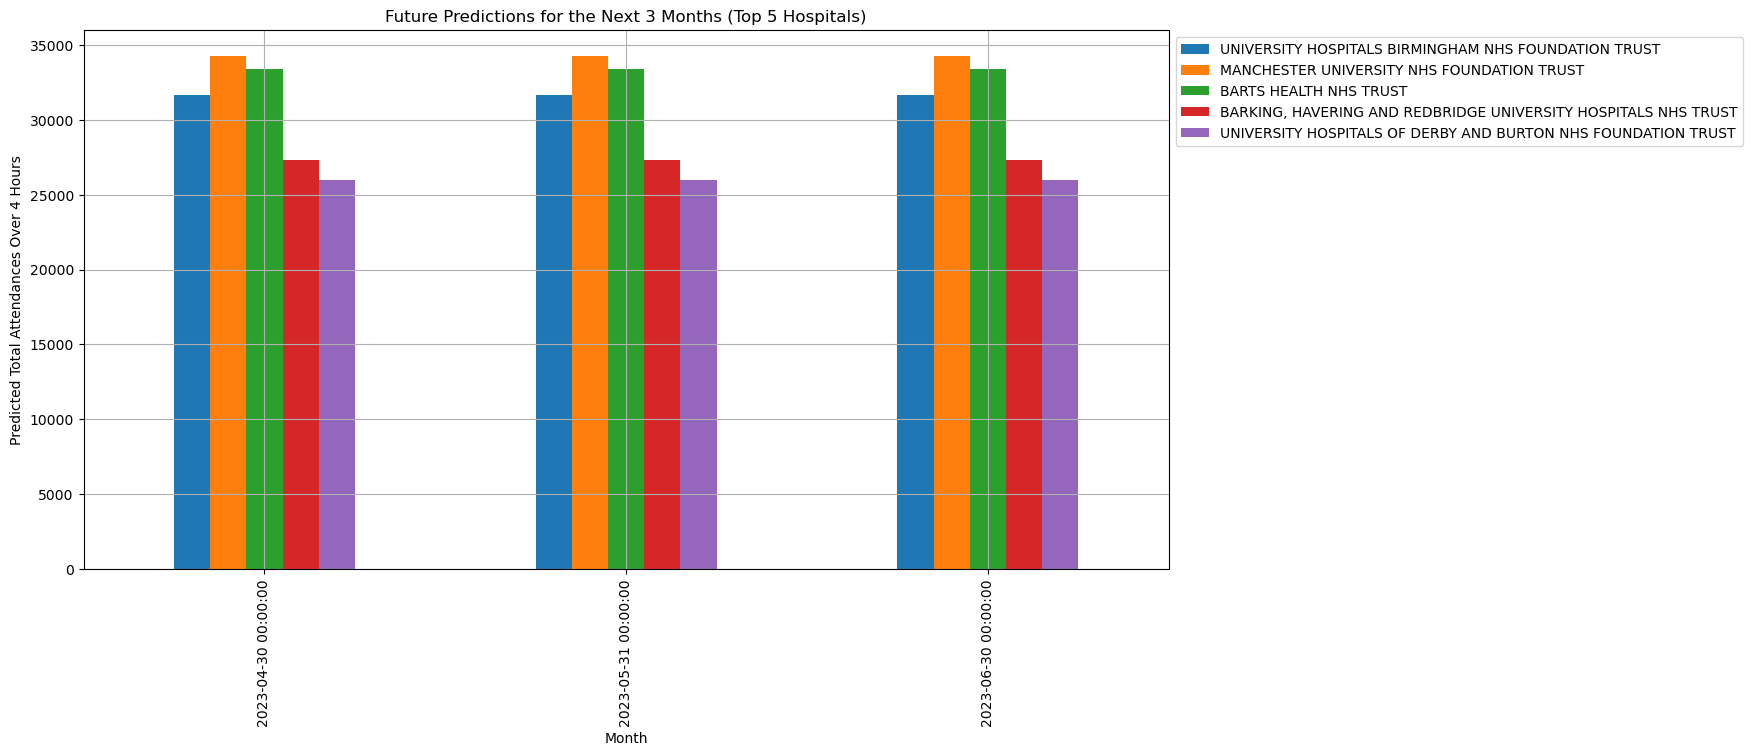

In [458]:
top_5_hospitals = [
    'UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION TRUST',
    'MANCHESTER UNIVERSITY NHS FOUNDATION TRUST',
    'BARTS HEALTH NHS TRUST',
    'BARKING, HAVERING AND REDBRIDGE UNIVERSITY HOSPITALS NHS TRUST',
    'UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS FOUNDATION TRUST'
]

future_predictions = pd.DataFrame(index=future_dates)

for hospital in top_5_hospitals:
    hospital_data = monthly_waiting_times[monthly_waiting_times['Org name'] == hospital]
    avg_values = hospital_data[['Attendances over 4hrs Type 1', 'Attendances over 4hrs Type 2', 'Attendances over 4hrs Other Department']].mean()
    
    X_new = pd.DataFrame({
        'Attendances over 4hrs Type 1': [avg_values['Attendances over 4hrs Type 1']] * len(future_dates),
        'Attendances over 4hrs Type 2': [avg_values['Attendances over 4hrs Type 2']] * len(future_dates),
        'Attendances over 4hrs Other Department': [avg_values['Attendances over 4hrs Other Department']] * len(future_dates)
    })
    
    y_new_pred = xgboost_model.predict(X_new)
    future_predictions[hospital] = y_new_pred

future_predictions.plot(kind='bar', figsize=(14, 7))
plt.title('Future Predictions for the Next 3 Months (Top 5 Hospitals)')
plt.xlabel('Month')
plt.ylabel('Predicted Total Attendances Over 4 Hours')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

This chart visualizes the predicted waiting times for the next three months using the XGBoost model, focusing on the top five hospitals with the highest waiting times: University Hospitals Birmingham NHS Foundation Trust, Manchester University NHS Foundation Trust, Barts Health NHS Trust, Barking, Havering and Redbridge University Hospitals NHS Trust, and University Hospitals of Derby and Burton NHS Foundation Trust.

Key Insights:

General Trend: The chart shows the total predicted waiting times for each month, based on average past data. The expected waiting times range between 20,000 and 35,000 for all hospitals, indicating a continued high patient load.

University Hospitals Birmingham (Blue Bar): This hospital is expected to have the highest waiting times, potentially struggling to manage high patient demand.

Manchester University (Orange Bar) and Barts Health (Green Bar): Both hospitals show similar waiting times, with Manchester slightly higher.

Barking, Havering and Redbridge (Red Bar): This hospital has higher predicted waiting times than Derby and Burton but lower compared to others.

University Hospitals of Derby and Burton (Purple Bar): This hospital has the lowest predicted waiting times, though still significant.

Conclusion: These predictions highlight the need for strategic planning to manage patient demand in the coming months. University Hospitals Birmingham may require more resources, while others should also assess their operational capacity to meet future demands.

# Conclusion and Future Work

In this project, I leveraged various machine learning models, including Random Forest and XGBoost, to predict patient waiting times in top NHS hospitals. The analysis highlighted critical patterns in the data, such as the consistently high waiting times at University Hospitals Birmingham NHS Foundation Trust and the relatively lower wait times at other hospitals. These insights underscore the pressing need for strategic planning and resource allocation in these hospitals to manage patient flow more effectively.

The XGBoost model, after thorough hyperparameter tuning, demonstrated strong predictive performance, making it a reliable tool for forecasting future waiting times. The predictions for the next three months provide a clear indication of potential challenges that hospitals may face, particularly in managing high patient volumes.

Future Work
Moving forward, several enhancements can be made to this analysis:

Incorporation of Additional Features: To improve model accuracy, incorporating more features such as hospital capacity, staffing levels, and seasonal trends could provide a more comprehensive view of the factors influencing waiting times.

Exploring Other Machine Learning Models: While XGBoost and Random Forest were effective, exploring other advanced models like Neural Networks or ensemble methods could further enhance predictive performance.

Real-Time Prediction Implementation: Implementing these models in a real-time setting could provide hospital administrators with up-to-date predictions, allowing for more dynamic and responsive management of resources.

Patient Outcome Integration: Integrating patient outcomes with waiting time predictions could help evaluate the impact of long wait times on patient care quality, providing a more holistic approach to hospital management.

Broader Data Scope: Expanding the dataset to include more hospitals or a longer historical period could provide a more robust foundation for the models, potentially uncovering additional patterns and trends.

This project serves as a crucial step towards more efficient hospital management by predicting future patient demands. However, continuous improvements and adaptations will be necessary to keep pace with the ever-changing healthcare landscape.